# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [ ]:
import random
dir(random)  # Reminding ourselves what we can do here

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=180.18849314523848, mobile=False), User(purchased=True, time_on_site=135.67700482149365, mobile=False), User(purchased=True, time_on_site=159.88535379510446, mobile=True), User(purchased=True, time_on_site=257.7835981679507, mobile=True), User(purchased=False, time_on_site=86.99445445027507, mobile=False), User(purchased=False, time_on_site=173.67358829592212, mobile=True), User(purchased=True, time_on_site=44.968058188901246, mobile=True), User(purchased=False, time_on_site=30.15219480121866, mobile=True), User(purchased=False, time_on_site=460.0007745853941, mobile=False), User(purchased=False, time_on_site=122.22911474525455, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,180.188493,False
1,True,135.677005,False
2,True,159.885354,True
3,True,257.783598,True
4,False,86.994454,False


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.395806383057993,5.457727420381445,6.012980358659168,6.370819673044487,6.526220869482321,6.618506115477453,6.744300972093091,6.937814523764514,7.022230321283178,7.738183255456649,...,570.7205763776294,572.579212329361,573.071762294419,577.5607756708825,578.0265919014007,578.8349054472059,584.0914381586123,586.960469433746,588.7975083689481,599.8083961016524
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,0,0,1,1
True,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,0


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,240,233,105,29,28
True,96,131,102,20,16


In [7]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,0.714286,0.64011,0.507246,0.591837,0.636364
True,0.285714,0.35989,0.492754,0.408163,0.363636


In [8]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.672,0.622667
True,0.328,0.377333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [7]:
## First key libraries
import pandas as pd
import numpy as np
import seaborn as sns

In [8]:
## Get the data into memory
df = pd.read_csv("persons.csv")
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [9]:
## Let's briefly desbribe the useful columns (non-index)
df1 = df[['age', 'weight', 'exercise_time']]
df1.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [10]:
## Quickly check for missing data
df1.isna().sum()

age              0
weight           0
exercise_time    0
dtype: int64

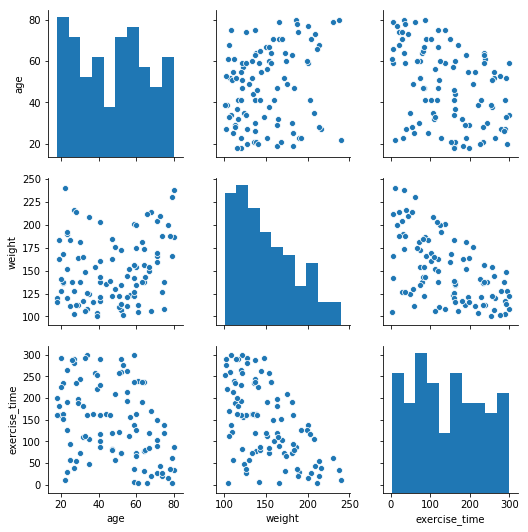

In [13]:
## Great.  Cleaning time isn't necessary.  Let's run a pairplot witgh a random sample of the data.
sns.pairplot(df1.sample(n=100))

In [80]:
## We can see some very similar trends in the weight/exercise time and age/weight.  
## Since weight is probably going to be the target variable in any model, I'd like to take a closer look at age/exercise
## Let's create age groups and see if we can suss out the same relationship for each

age_labels = [''.join([str(10*x),'-',str(10*x+9)]) for x in range(9)]
weight_labels = [''.join([str(25*x),'-',str(25*x+24)]) for x in range(9)]
# df1['age_range'] = pd.cut(df1['age'], 9, labels=age_labels)
# df1['weight_range'] = pd.cut(df1['weight'], 9, labels=weight_labels)
## Unfortunately, binning with .cut does not yield the correct result. Bins are not distributed
## evenly between ordinal periods (10yr age gaps or 25lb weight ranges)

## Manual encoding


def gen_label(val, width, bins):
'''
val: integer to find bin label
width: width of bin
bins: number of bins

Hopefully fast.  Takes the value to lookup, the width of the bin and # of bins.
Creates a map and searches for the correct bin (float/integer values only).
Returns a string with the range 'min-max' of bin.
'''

    label_map = [[width*x, width*x+width-1] for x in range(bins)]
    
    for i in range(bins):
        if val <= label_map[i][1]:
            print(label_map)
            return ''.join([str(label_map[i][0]), '-',str(label_map[i][1])])
    
    return 'Out of Range'

In [87]:
df1['age_range'] = df1.age.apply(gen_label, width=10, bins=9)
df1['weight_range'] = df1.weight.apply(gen_label, width=25, bins=9)

df1.head()

[[0, 9], [10, 19], [20, 29], [30, 39], [40, 49], [50, 59], [60, 69], [70, 79], [80, 89]]
[[0, 9], [10, 19], [20, 29], [30, 39], [40, 49], [50, 59], [60, 69], [70, 79], [80, 89]]
[[0, 9], [10, 19], [20, 29], [30, 39], [40, 49], [50, 59], [60, 69], [70, 79], [80, 89]]
[[0, 9], [10, 19], [20, 29], [30, 39], [40, 49], [50, 59], [60, 69], [70, 79], [80, 89]]
[[0, 9], [10, 19], [20, 29], [30, 39], [40, 49], [50, 59], [60, 69], [70, 79], [80, 89]]
[[0, 9], [10, 19], [20, 29], [30, 39], [40, 49], [50, 59], [60, 69], [70, 79], [80, 89]]
[[0, 9], [10, 19], [20, 29], [30, 39], [40, 49], [50, 59], [60, 69], [70, 79], [80, 89]]
[[0, 9], [10, 19], [20, 29], [30, 39], [40, 49], [50, 59], [60, 69], [70, 79], [80, 89]]
[[0, 9], [10, 19], [20, 29], [30, 39], [40, 49], [50, 59], [60, 69], [70, 79], [80, 89]]
[[0, 9], [10, 19], [20, 29], [30, 39], [40, 49], [50, 59], [60, 69], [70, 79], [80, 89]]
[[0, 9], [10, 19], [20, 29], [30, 39], [40, 49], [50, 59], [60, 69], [70, 79], [80, 89]]
[[0, 9], [10, 19], [2

[[0, 24], [25, 49], [50, 74], [75, 99], [100, 124], [125, 149], [150, 174], [175, 199], [200, 224]]
[[0, 24], [25, 49], [50, 74], [75, 99], [100, 124], [125, 149], [150, 174], [175, 199], [200, 224]]
[[0, 24], [25, 49], [50, 74], [75, 99], [100, 124], [125, 149], [150, 174], [175, 199], [200, 224]]
[[0, 24], [25, 49], [50, 74], [75, 99], [100, 124], [125, 149], [150, 174], [175, 199], [200, 224]]
[[0, 24], [25, 49], [50, 74], [75, 99], [100, 124], [125, 149], [150, 174], [175, 199], [200, 224]]
[[0, 24], [25, 49], [50, 74], [75, 99], [100, 124], [125, 149], [150, 174], [175, 199], [200, 224]]
[[0, 24], [25, 49], [50, 74], [75, 99], [100, 124], [125, 149], [150, 174], [175, 199], [200, 224]]
[[0, 24], [25, 49], [50, 74], [75, 99], [100, 124], [125, 149], [150, 174], [175, 199], [200, 224]]
[[0, 24], [25, 49], [50, 74], [75, 99], [100, 124], [125, 149], [150, 174], [175, 199], [200, 224]]
[[0, 24], [25, 49], [50, 74], [75, 99], [100, 124], [125, 149], [150, 174], [175, 199], [200, 224]]


,age,weight,exercise_time,age_range,weight_range
0,44,118,192,40-49,100-124
1,41,161,35,40-49,150-174
2,46,128,220,40-49,125-149
3,39,216,57,30-39,200-224
4,28,116,182,20-29,100-124


In [88]:
## Quick look at cross tab
pd.crosstab(df1['weight_range'], df1['age_range'])

age_range,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89
weight_range,,,,,,,,
100-124,10,55,67,43,50,30,39,0
125-149,10,54,52,59,51,49,34,4
150-174,11,44,36,36,34,45,41,3
175-199,7,20,34,19,31,38,33,4
200-224,5,15,19,17,17,23,23,4
Out of Range,0,4,4,5,1,7,9,4


(array([135., 140., 151., 127., 129., 128., 123., 152., 115.]),
 array([18.        , 24.88888889, 31.77777778, 38.66666667, 45.55555556,
        52.44444444, 59.33333333, 66.22222222, 73.11111111, 80.        ]),
 <a list of 9 Patch objects>)

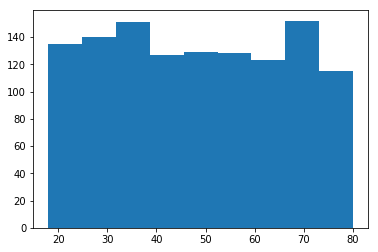

In [53]:
## Interesting.  Firstly, we can check the histogram to see about distribution of age
from matplotlib import pyplot as plt

plt.hist(df1['age'], bins=9)
## Age is well distributed. 

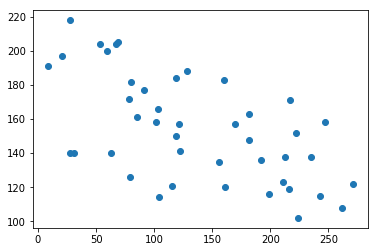

In [93]:
## Let's try isolating a single age group and checking the relation of weight vs exercise
age_labels = [''.join([str(10*x),'-',str(10*x+9)]) for x in range(9)]
weight_labels = [''.join([str(25*x),'-',str(25*x+24)]) for x in range(9)]

subset = df1.loc[df1['age_range'] == '10-19']
X = subset['exercise_time']
Y = subset['weight']

## generate plot
plt.scatter(X,Y)

In [96]:
## Great!  This will work.  Let's clean this up by fitting a line to the subset of data
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

<class 'pandas.core.series.Series'>


18      271
20       28
83      104
110     222
171     235
203     161
259      21
294      85
306     160
323     217
337      91
351     262
372     119
444     115
469     243
532      80
551       9
562     103
573     128
622     122
648      28
655     213
656      69
685      78
744     156
754     119
830      31
840      79
882     121
905      67
906     224
973     247
983     216
1002    170
1026    211
1045    182
1080     63
1095     53
1108    199
1125     59
1140    102
1147    182
1148    192
Name: exercise_time, dtype: int64

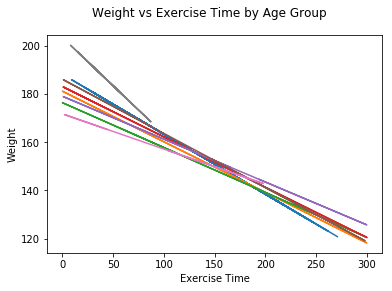

In [110]:
## Best Practice: First we'll split the data into test and training set
## X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

## For timesake, just to get a few quick lines
age_labels = [''.join([str(10*x),'-',str(10*x+9)]) for x in range(9)]
weight_labels = [''.join([str(25*x),'-',str(25*x+24)]) for x in range(9)]

for group in age_labels[1:]:
    subset = df1.loc[df1['age_range'] == group]

    model = linear_model.LinearRegression()
    X = subset['exercise_time'].values.reshape(-1,1)
    Y = subset['weight'].values.reshape(-1,1)
    model.fit(X, Y) 
    plt.plot(X, model.predict(X))
    
plt.suptitle("Weight vs Exercise Time by Age Group")
plt.xlabel("Exercise Time")
plt.ylabel("Weight")
plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

All the variables are continuous (except the index)

2.  What are the relationships between the variables?

There are relations negative relationships between age/exercise time & exercise time/weight, a beta relationship with age and weight somehow, 

3.  Which relationships are "real", and which spurious?

The relationship between exercise time and weight is real.  The relationship between age and exercise time is spurious as there is a similar reduction in exercise time with age.  Weight is more a factor of exercise time than of age, I think. 


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)